In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from pathlib import Path
data_dir = Path(r"C:\Users\kiara\Documents\ADS-505-Final-Project-Pharma-Sales-Forecast\data\processed")
train_path = data_dir / "salesdaily_train_fe.csv"
test_path = data_dir / "salesdaily_test_fe.csv"

# Load data 
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1795, 24)
Test shape: (281, 24)


,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,...,month,day,dayofweek,is_weekend,total_sales,total_sales_lag_1,total_sales_lag_7,total_sales_lag_30,rolling_mean_7,rolling_std_7
0,2014-02-01,4.33,4.32,5.0,43.0,13.0,1.0,14.0,0.0,2014,...,2,1,5,1,84.65,47.68,81.80,48.47,51.915714,15.821377
1,2014-02-02,7.00,3.00,0.2,13.5,6.0,2.0,8.0,0.0,2014,...,2,2,6,1,39.70,84.65,34.01,107.00,52.322857,16.729208
2,2014-02-03,5.00,1.00,8.5,32.4,16.0,1.0,1.0,0.0,2014,...,2,3,0,0,64.90,39.70,56.81,91.35,53.135714,15.803739
3,2014-02-04,1.33,3.00,7.0,30.6,8.0,1.0,17.0,2.0,2014,...,2,4,1,0,69.93,64.90,58.52,66.10,54.291429,16.401714
4,2014-02-05,3.00,4.02,6.2,32.4,15.0,1.0,1.0,1.0,2014,...,2,5,2,0,63.62,69.93,39.33,58.20,55.921429,17.426910


In [4]:
# target
y_train = train['total_sales'].copy()
y_test  = test['total_sales'].copy()

# Features
X_train = train.drop(columns=['total_sales', 'datum'], errors='ignore')
X_test  = test.drop(columns=['total_sales', 'datum'],  errors='ignore')

# One-hot encode any remaining categoricals (e.g., Weekday Name)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test,  drop_first=True)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("X_train dtypes OK? ->", all(dt.kind in "biufc" for dt in X_train.dtypes))
print("Shapes:", X_train.shape, X_test.shape)

X_train dtypes OK? -> True
Shapes: (1795, 22) (281, 22)


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = sqrt(((y_test - y_pred)**2).mean())
r2   = r2_score(y_test, y_pred)

print(f"Random Forest — MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

Random Forest — MAE: 3.62 | RMSE: 5.77 | R²: 0.939


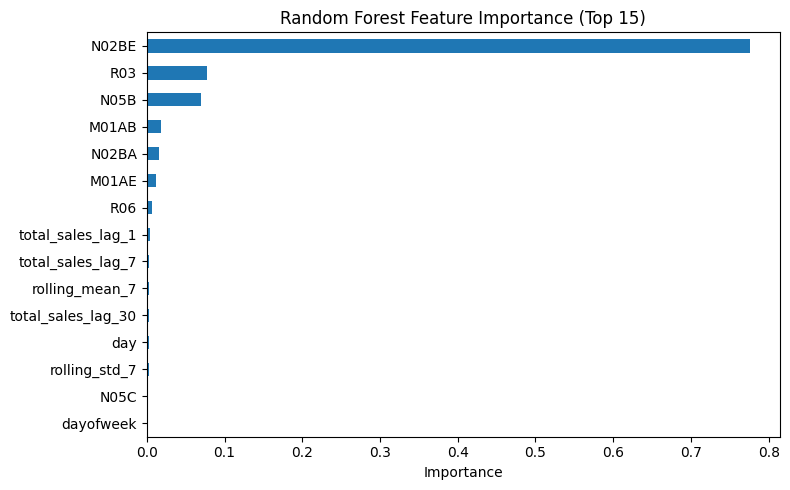

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top15 = importances.head(15)

plt.figure(figsize=(8,5))
top15[::-1].plot(kind="barh")
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

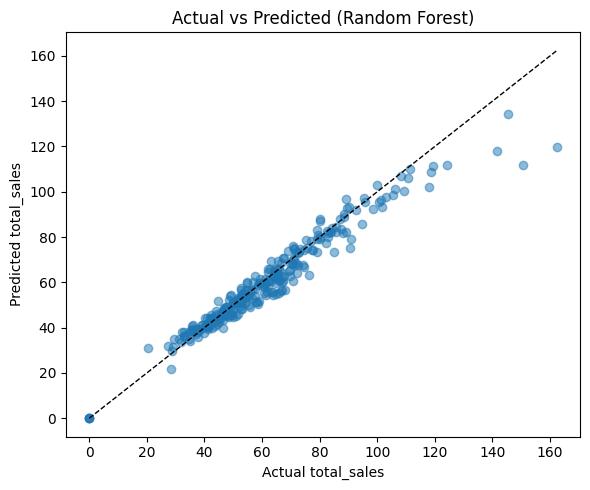

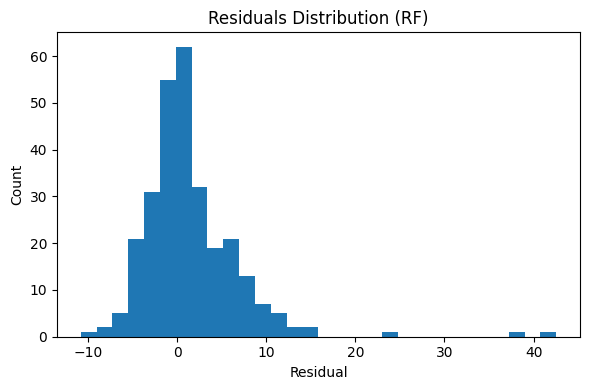

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Actual total_sales")
plt.ylabel("Predicted total_sales")
plt.title("Actual vs Predicted (Random Forest)")
plt.tight_layout()
plt.show()

resid = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("Residuals Distribution (RF)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### XGBoost

In [12]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

print("xgboost version:", xgb.__version__)

xgb_model = XGBRegressor(
    n_estimators=600,        
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",   
    
)

# Fit 
xgb_model.fit(X_train, y_train)

# Predict & evaluate
xgb_preds = xgb_model.predict(X_test)

xgb_mae  = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2   = r2_score(y_test, xgb_preds)

print(f"XGBoost — MAE: {xgb_mae:.2f} | RMSE: {xgb_rmse:.2f} | R²: {xgb_r2:.3f}")

xgboost version: 3.0.5
XGBoost — MAE: 2.14 | RMSE: 4.02 | R²: 0.971


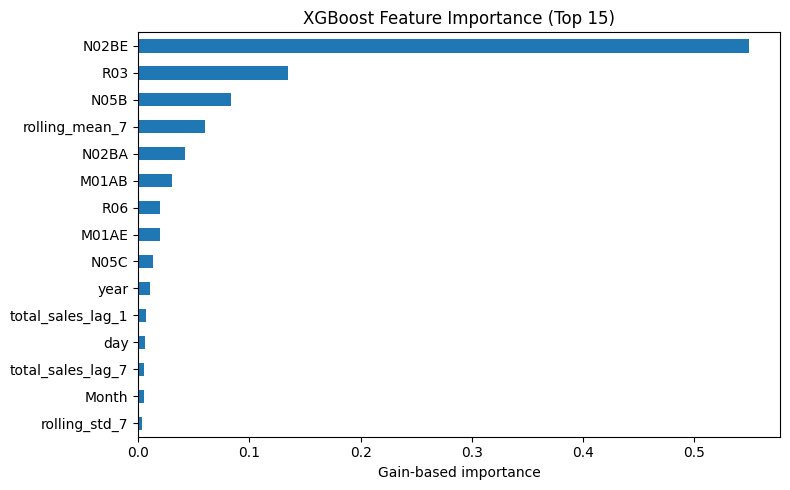

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Top 15 feature importances
imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
imp[::-1].plot(kind="barh")
plt.title("XGBoost Feature Importance (Top 15)")
plt.xlabel("Gain-based importance")
plt.tight_layout(); plt.show()

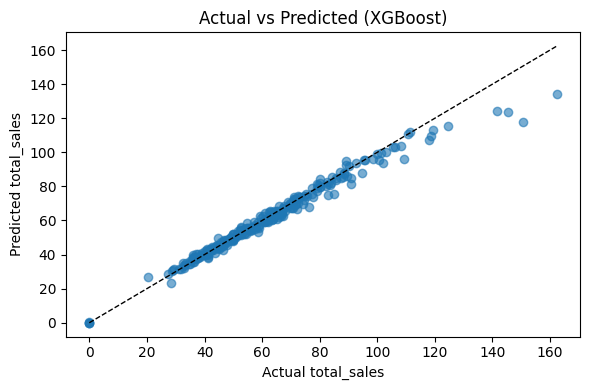

In [14]:
# Actual vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, xgb_preds, alpha=0.6)
mn, mx = float(min(y_test.min(), xgb_preds.min())), float(max(y_test.max(), xgb_preds.max()))
plt.plot([mn, mx], [mn, mx], 'k--', lw=1)
plt.xlabel("Actual total_sales"); plt.ylabel("Predicted total_sales")
plt.title("Actual vs Predicted (XGBoost)")
plt.tight_layout(); plt.show()

In [19]:
# Random Forest metric
rf_mae = 3.70
rf_rmse = 5.77
rf_r2 = 0.939

# XGBoost metrics
xgb_mae = 2.14
xgb_rmse = 4.02
xgb_r2 = 0.971

import pandas as pd

results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [rf_mae, xgb_mae],
    "RMSE": [rf_rmse, xgb_rmse],
    "R²": [rf_r2, xgb_r2]
})

results = results.round(3).sort_values(by="R²", ascending=False).reset_index(drop=True)
display(results)


,Model,MAE,RMSE,R²
0,XGBoost,2.14,4.02,0.971
1,Random Forest,3.70,5.77,0.939
